In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from alpha_vantage.techindicators import TechIndicators
from utils import *

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Dropout, MaxPooling1D, Activation, GlobalMaxPooling1D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

np.random.seed(1)

#### Obtain price data and technical indicators

Don't need to run if data is available.

In [ ]:
start_date = datetime.datetime(2002, 1, 1)
end_date = datetime.datetime(2003, 1, 1)

ticker = "EA"

history = yf.Ticker(ticker).history(start=start_date, end=end_date)
history["Close"].plot()

In [ ]:
intervals = np.arange(6, 21)

In [ ]:
sma = get_sma(ticker, intervals, start_date, end_date)
ema = get_ema(ticker, intervals, start_date, end_date)
wma = get_wma(ticker, intervals, start_date, end_date)
t3 = get_t3(ticker, intervals, start_date, end_date)
rsi = get_rsi(ticker, intervals, start_date, end_date)
willr = get_willr(ticker, intervals, start_date, end_date)
adx = get_adx(ticker, intervals, start_date, end_date)
mom = get_mom(ticker, intervals, start_date, end_date)
cci = get_cci(ticker, intervals, start_date, end_date)
cmo = get_cmo(ticker, intervals, start_date, end_date)
roc = get_roc(ticker, intervals, start_date, end_date)
mfi = get_mfi(ticker, intervals, start_date, end_date)
trix = get_trix(ticker, intervals, start_date, end_date)
dx = get_dx(ticker, intervals, start_date, end_date)
trima = get_trima(ticker, intervals, start_date, end_date)

In [ ]:
df = pd.concat([history, ema, sma, wma, trima, t3, rsi, willr, adx, mom, cci, cmo, roc, mfi, trix, dx], axis=1)
df = df.dropna()
df = df.drop(["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"], axis=1)
df = df.rename(columns={"Close": "close"})
# df.to_csv("EA.csv", index_label="date")

#### Read data and create labels

In [2]:
df = pd.read_csv("EA_15.csv")
df = df.set_index("date")
df.index = pd.to_datetime(df.index)
df

,close,ema_6,ema_7,ema_8,ema_9,ema_10,ema_11,ema_12,ema_13,ema_14,...,dx_11,dx_12,dx_13,dx_14,dx_15,dx_16,dx_17,dx_18,dx_19,dx_20
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,29.831154,29.8857,29.9079,29.9311,29.9523,29.9695,29.9815,29.9879,29.9887,29.9841,...,21.5320,21.6341,21.6598,21.6090,21.4878,21.3045,21.0685,20.7886,20.4732,20.1298
2002-01-03,30.257881,29.9919,29.9952,30.0036,30.0133,30.0218,30.0275,30.0293,30.0270,30.0205,...,28.3483,27.7211,27.1564,26.6202,26.0943,25.5694,25.0414,24.5095,23.9745,23.4381
2002-01-04,31.240339,30.3484,30.3064,30.2783,30.2586,30.2432,30.2295,30.2156,30.2003,30.1831,...,41.5495,39.7818,38.2503,36.8896,35.6552,34.5166,33.4532,32.4507,31.4990,30.5911
2002-01-07,29.478857,30.0998,30.0993,30.1005,30.1025,30.1042,30.1043,30.1021,30.0971,30.0891,...,17.9832,18.5187,18.9138,19.1858,19.3510,19.4245,19.4197,19.3490,19.2232,19.0518
2002-01-08,29.076939,29.8074,29.8436,29.8729,29.8973,29.9173,29.9330,29.9443,29.9513,29.9541,...,8.6640,9.9726,11.0351,11.8882,12.5631,13.0867,13.4821,13.7690,13.9643,14.0826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,132.860870,131.1931,130.8829,130.6026,130.3558,130.1444,129.9682,129.8259,129.7150,129.6328,...,28.9088,24.8694,21.4667,18.5915,16.1511,14.0694,12.2845,10.7461,9.4134,8.2536
2021-12-28,133.290298,131.7908,131.4835,131.1987,130.9417,130.7155,130.5211,130.3581,130.2250,130.1198,...,35.9271,31.4567,27.6420,24.3822,21.5879,19.1830,17.1039,15.2983,13.7230,12.3424
2021-12-29,132.960739,132.1237,131.8516,131.5892,131.3445,131.1228,130.9269,130.7577,130.6151,130.4980,...,23.2554,20.5414,18.1163,15.9716,14.0844,12.4269,10.9708,9.6902,8.5618,7.5652


In [3]:
df.describe()

,close,ema_6,ema_7,ema_8,ema_9,ema_10,ema_11,ema_12,ema_13,ema_14,...,dx_11,dx_12,dx_13,dx_14,dx_15,dx_16,dx_17,dx_18,dx_19,dx_20
count,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,...,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000
mean,57.841513,57.788872,57.778811,57.768801,57.758834,57.748901,57.738988,57.729091,57.719197,57.709299,...,26.520804,25.429902,24.466555,23.603411,22.830420,22.129612,21.491481,20.914750,20.381940,19.887206
std,38.012829,37.950243,37.939090,37.928089,37.917207,37.906418,37.895694,37.885017,37.874367,37.863727,...,18.218356,17.618351,17.083590,16.608055,16.171689,15.773381,15.405579,15.053458,14.727894,14.425891
min,10.866638,11.197500,11.232900,11.265200,11.295200,11.323400,11.350300,11.376400,11.401900,11.426800,...,0.027300,0.001300,0.021100,0.003300,0.005000,0.000600,0.000700,0.007200,0.001000,0.007300
25%,24.691830,24.747325,24.764825,24.804150,24.838150,24.863225,24.906775,24.937575,24.959425,24.985900,...,11.444900,10.720175,10.152700,9.798775,9.514750,9.305900,9.043875,8.656475,8.406475,8.196300
50%,49.659046,49.726050,49.721100,49.710200,49.738600,49.716450,49.725550,49.737550,49.756000,49.752850,...,23.546950,22.324550,21.349600,20.510300,19.611800,18.950300,18.329200,17.699450,17.184350,16.731000
75%,81.236795,81.419675,81.412050,81.319950,81.296925,81.266775,81.227475,81.213950,81.130375,81.084375,...,39.058350,37.756375,36.271125,34.981100,34.038175,33.062975,32.020300,31.157900,30.304925,29.484800
max,148.032883,146.603000,146.383400,146.201400,146.016600,145.827200,145.636000,145.444500,145.280200,145.113000,...,88.786300,87.838300,86.904700,85.983400,85.073000,84.172300,83.280300,82.396200,81.519400,80.649400


In [4]:
labels = create_labels(df, window_size=3)
df["labels"] = labels.astype(int)
df

--- Creating labels ---


5036it [00:01, 3883.71it/s]


,close,ema_6,ema_7,ema_8,ema_9,ema_10,ema_11,ema_12,ema_13,ema_14,...,dx_12,dx_13,dx_14,dx_15,dx_16,dx_17,dx_18,dx_19,dx_20,labels
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,29.831154,29.8857,29.9079,29.9311,29.9523,29.9695,29.9815,29.9879,29.9887,29.9841,...,21.6341,21.6598,21.6090,21.4878,21.3045,21.0685,20.7886,20.4732,20.1298,0
2002-01-03,30.257881,29.9919,29.9952,30.0036,30.0133,30.0218,30.0275,30.0293,30.0270,30.0205,...,27.7211,27.1564,26.6202,26.0943,25.5694,25.0414,24.5095,23.9745,23.4381,2
2002-01-04,31.240339,30.3484,30.3064,30.2783,30.2586,30.2432,30.2295,30.2156,30.2003,30.1831,...,39.7818,38.2503,36.8896,35.6552,34.5166,33.4532,32.4507,31.4990,30.5911,0
2002-01-07,29.478857,30.0998,30.0993,30.1005,30.1025,30.1042,30.1043,30.1021,30.0971,30.0891,...,18.5187,18.9138,19.1858,19.3510,19.4245,19.4197,19.3490,19.2232,19.0518,2
2002-01-08,29.076939,29.8074,29.8436,29.8729,29.8973,29.9173,29.9330,29.9443,29.9513,29.9541,...,9.9726,11.0351,11.8882,12.5631,13.0867,13.4821,13.7690,13.9643,14.0826,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,132.860870,131.1931,130.8829,130.6026,130.3558,130.1444,129.9682,129.8259,129.7150,129.6328,...,24.8694,21.4667,18.5915,16.1511,14.0694,12.2845,10.7461,9.4134,8.2536,2
2021-12-28,133.290298,131.7908,131.4835,131.1987,130.9417,130.7155,130.5211,130.3581,130.2250,130.1198,...,31.4567,27.6420,24.3822,21.5879,19.1830,17.1039,15.2983,13.7230,12.3424,0
2021-12-29,132.960739,132.1237,131.8516,131.5892,131.3445,131.1228,130.9269,130.7577,130.6151,130.4980,...,20.5414,18.1163,15.9716,14.0844,12.4269,10.9708,9.6902,8.5618,7.5652,1


In [5]:
print(f"Sell {sum(labels == 0)}")
print(f"Buy {sum(labels == 1)}")
print(f"Hold {sum(labels == 2)}")

Sell 1298
Buy 1295
Hold 2443


In [6]:
num_features = len(df.columns) - 1
shape = (int(np.sqrt(num_features)), int(np.sqrt(num_features)))

In [7]:
minmax = MinMaxScaler(feature_range=(0, 1))

x = np.array(df.loc[:, "ema_6":"dx_20"])
x_norm = minmax.fit_transform(x)
x_reshaped = reshape_data(x_norm, shape[0], shape[1])

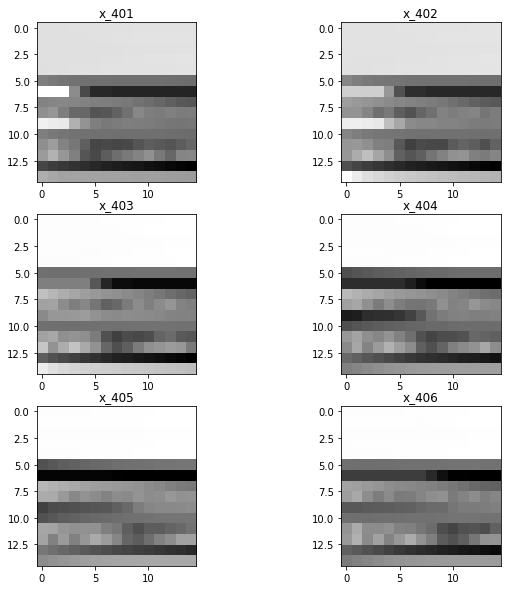

In [8]:
w = 10
h = 10

fig = plt.figure(figsize=(w, h))
for i in range(1, 7):
    fig.add_subplot(3, 2, i)
    img = x_reshaped[i+400]
    plt.title(f"x_{i+400}")
    plt.imshow(img, cmap="binary")

plt.show()

#### Split data into training and testing sets

In [9]:
start_year = 2002
end_year = 2021

train_data = []
test_data = []

for i in range(start_year, end_year-4):
    df_train = pd.concat([df[df.index.year == i+j] for j in range(4)])
    df_test = df[df.index.year == i+4]

    train_data.append(df_train)
    test_data.append(df_test)

In [10]:
x_train, y_train = [], []
x_test, y_test = [], []

temp = []

for i in range(len(train_data)):
    minmax = MinMaxScaler(feature_range=(0, 1))

    x = np.array(train_data[i].loc[:, "ema_6":"dx_20"])
    _x_norm = minmax.fit_transform(x)
    _x_reshaped = reshape_data(_x_norm, shape[0], shape[1])

    y = np.array(train_data[i].loc[:, "labels"])
    y_cat = to_categorical(y)

    temp = np.concatenate((temp, y), axis=None)
    x_train.append(_x_reshaped)
    y_train.append(y_cat)

for i in range(len(test_data)):
    minmax = MinMaxScaler(feature_range=(0, 1))
    
    x = np.array(test_data[i].loc[:, "ema_6":"dx_20"])
    _x_norm = minmax.fit_transform(x)
    _x_reshaped = reshape_data(_x_norm, shape[0], shape[1])

    y = np.array(test_data[i].loc[:, "labels"])
    y_cat = to_categorical(y)

    x_test.append(_x_reshaped)
    y_test.append(y_cat)

sample_weights = get_sample_weights(temp)

Class weights [1.30153395 1.30086133 0.68354831]
Value counts: (array([0, 1, 2]), array([3868, 3870, 7365]))


#### Create and train model

In [20]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(15,15,1)))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu", input_shape=(15,15,1)))
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 13, 13, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                16010     
                                                      

13/13 [==============================] - 0s 19ms/step - loss: 0.9632 - accuracy: 0.4925 - f1_score: 0.1889 - val_loss: 0.9847 - val_accuracy: 0.4802 - val_f1_score: 0.2619 - lr: 0.0010


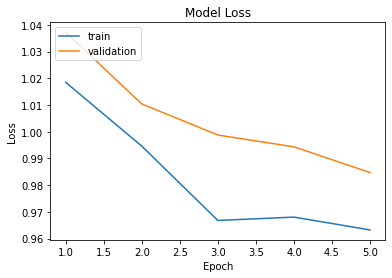

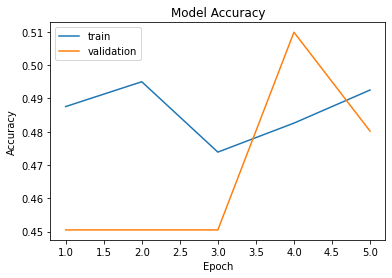

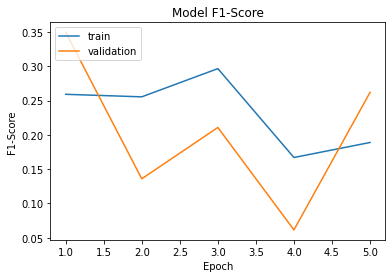

In [21]:
EPOCHS = 5
BATCH_SIZE = 64

optimizer = Adam(learning_rate=0.0005)

model.compile(loss="categorical_crossentropy", metrics=["accuracy", f1_score])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=100, min_delta=0.0001)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=10, verbose=1, mode='min',
                        min_delta=0.001, cooldown=1, min_lr=0.0001)
# mcp = ModelCheckpoint("tugas3/best_model", monitor='val_loss', verbose=0,
#                       save_best_only=True, save_weights_only=False, mode='min', period=1)

train_history = {"loss":[],
                 "accuracy":[],
                 "f1_score":[],
                 "val_loss":[],
                 "val_accuracy":[],
                 "val_f1_score":[]}

for epoch in range(EPOCHS):
    for i in range(len(x_train)):
        hist = model.fit(x_train[i], y_train[i], validation_split=0.2, 
                         sample_weight=sample_weights, 
                         callbacks=[es, rlp],
                         batch_size=BATCH_SIZE, epochs=1)

    train_history["loss"] += hist.history["loss"]
    train_history["accuracy"] += hist.history["accuracy"]
    train_history["f1_score"] += hist.history["f1_score"]
    train_history["val_loss"] += hist.history["val_loss"]
    train_history["val_accuracy"] += hist.history["val_accuracy"]
    train_history["val_f1_score"] += hist.history["val_f1_score"]

plot_history(train_history)